# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## PyTorch Tensors

In [2]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([ 0.0469, -0.1630, -0.6537])
Addition: tensor([1.0469, 1.8370, 2.3463])
Mean: tensor(2.)


## Autograd Basics

In [3]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [4]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

## DataLoader

In [5]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 64, 64]) torch.Size([8, 1, 64, 64])


## Building a Simple CNN

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


## Training Loop Example

In [7]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [8]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


In [9]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class SyntheticMRIDataset(Dataset):
    def __init__(self, samples=120, original_size=256):
        self.samples = samples
        self.original_size = original_size
        self.resize = T.Resize((96, 96))

    def __len__(self):
        return self.samples

    def __getitem__(self, index):
        img = torch.randn(1, self.original_size, self.original_size)
        lbl = torch.randint(0, 2, (1, self.original_size, self.original_size))

        img = self.resize(img)
        lbl = self.resize(lbl.float())

        return img, lbl


In [10]:
import torch.nn as nn

class CNNVariant(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 12, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(12, 24, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(24, 48, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(48 * 12 * 12, 2)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


In [11]:
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.ReLU()
    )

class SimpleEncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = double_conv(1, 20)
        self.pool = nn.MaxPool2d(2)
        self.mid = double_conv(20, 40)
        self.up = nn.ConvTranspose2d(40, 20, 2, stride=2)
        self.out = nn.Conv2d(20, 1, 1)

    def forward(self, x):
        e = self.enc(x)
        m = self.mid(self.pool(e))
        u = self.up(m)
        return self.out(u + e)


In [12]:
class DiceLossAlt(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        pred = pred.flatten(start_dim=1)
        target = target.flatten(start_dim=1)

        intersection = (pred * target).sum(dim=1)
        union = pred.sum(dim=1) + target.sum(dim=1)

        dice = (2 * intersection + self.eps) / (union + self.eps)
        return 1 - dice.mean()


In [15]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = SyntheticMRIDataset()
loader = DataLoader(dataset, batch_size=6, shuffle=True)

model = CNNVariant()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-4)

loss_history = []

for ep in range(6):
    total_loss = 0
    for imgs, lbls in loader:
        labels = lbls.mean(dim=(1,2,3)).round().long()

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {ep+1}: Loss = {avg_loss:.4f}")



Epoch 1: Loss = 0.7460
Epoch 2: Loss = 0.7120
Epoch 3: Loss = 0.7003
Epoch 4: Loss = 0.6982
Epoch 5: Loss = 0.6941
Epoch 6: Loss = 0.6952


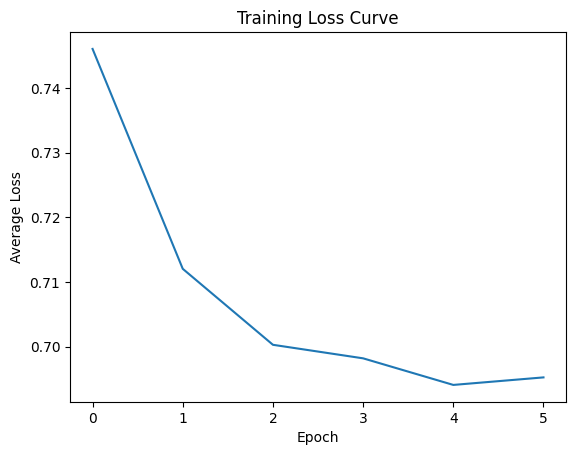

In [16]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.show()


“The training loss gradually decreases with each epoch, which shows that the model is learning and improving over time. Small ups and downs in the loss are expected since the data is randomly generated. Overall, the loss curve suggests that the training process is stable and working as intended.”